In [41]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf  
import pathlib
import math
import os
import re
import cv2
import sklearn
from PIL import Image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from sklearn.metrics import f1_score
import pickle

<h3>Configure Tensorflow</h3>

In [2]:
config = tf.compat.v1.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
config.log_device_placement = True  # to log device placement (on which device the operation ran)  
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.compat.v1.Session(config=config)  
tf.compat.v1.keras.backend.set_session(sess)  # set this TensorFlow session as the default session for Keras  


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:08:00.0, compute capability: 7.5



<h3> Load dataset </h3>

In [3]:
load_pickle = True # set to true so you don't have to process and save the entire dataset

if load_pickle:
    images = pickle.load(open("../saved/images.p", "rb"))
    images_test =pickle.load(open("../saved/images_test.p", "rb"))
    
    labels = pickle.load(open("../saved/labels.p", "rb"))
    labels_test = pickle.load(open("../saved/labels_test.p", "rb"))
    
else:
    dataset_path = '../histology_slides/'
    dataset_path = pathlib.Path(dataset_path)

    # width and height of images
    image_size = 224

    images = []
    labels = [] # 0: benign, 1: malignant

    num_malign = 0
    total = 0

    # search every file in the directory
    for path in dataset_path.rglob("*"):
        filename, file_extension = os.path.splitext(path)

        # find images
        if file_extension == '.png':
            #filename format:
            #<BIOPSY_PROCEDURE>_<TUMOR_CLASS>_<TUMOR_TYPE>_<YEAR>-<SLIDE_ID>-<MAGNIFICATION>-<SEQ>
            meta = re.split('_|-', os.path.basename(filename)) # metadata

            # get label
            if meta[1] == 'M':
                labels.append(1)
                num_malign += 1
            else:
                labels.append(0)
            # load image
            img = np.asarray(Image.open(path).convert("RGB"))
            img = cv2.resize(img, (image_size, image_size))
            #uses a ton of memory to hold floating points
            img = img / 255.0 # scale pixel data between 0 and 1
            images.append(img)

            total += 1
            print('%d images loaded\r' % (total), end="")

    print('%d images loaded' % (total))
    print('malignant percentage: %d%%' % (num_malign / len(labels) * 100))

    # Split training and testing sets ------------------------------

    test_set_percentage = 20

    #shuffle images and labels in the same order
    images, labels = sklearn.utils.shuffle(images, labels)

    #num samples in test set
    test_size = math.floor(total * test_set_percentage / 100)

    #use the last n samples of the list for testing
    images_test = images[total - test_size : total]
    #trim off the last n samples of the list from the main training set
    images = images[0 : total - test_size]

    #same as above
    labels_test = labels[total - test_size: total]
    labels = labels[0 : total - test_size]

    #convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    images_test = np.array(images_test)
    labels_test = np.array(labels_test)

    print(str(len(images)) + ' samples in training set')
    print(str(len(images_test)) + ' samples in testing set')
    
    pickle.dump(images, open("../saved/images.p", "wb"), protocol=4)
    pickle.dump(images_test, open("../saved/images_test.p", "wb"), protocol=4)
    
    pickle.dump(labels, open("../saved/labels.p", "wb"), protocol=4)
    pickle.dump(labels_test, open("../saved/labels_test.p", "wb"), protocol=4)

<h3>Create Model</h3>

In [43]:
model = load_model('../saved/parameters.h5')

In [11]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape = images.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation = "sigmoid"))

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',#Adam(lr=1e-4),
    metrics=['accuracy']
)

<h3>Train Model</h3>

In [24]:
history = model.fit(images, labels, epochs=30, batch_size = 16, validation_data = (images_test, labels_test), shuffle = True)

Train on 6328 samples, validate on 1581 samples
Epoch 1/30
6328/6328 [==============================] - 14s 2ms/sample - loss: 0.0615 - accuracy: 0.9823 - val_loss: 0.0981 - val_accuracy: 0.9798
Epoch 2/30
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0561 - accuracy: 0.9810 - val_loss: 0.0793 - val_accuracy: 0.9791
Epoch 3/30
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0494 - accuracy: 0.9828 - val_loss: 0.1022 - val_accuracy: 0.9747
Epoch 4/30
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0453 - accuracy: 0.9842 - val_loss: 0.0750 - val_accuracy: 0.9772
Epoch 5/30
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0532 - accuracy: 0.9812 - val_loss: 0.0864 - val_accuracy: 0.9747
Epoch 6/30
6328/6328 [==============================] - 12s 2ms/sample - loss: 0.0463 - accuracy: 0.9844 - val_loss: 0.1039 - val_accuracy: 0.9798
Epoch 7/30
6328/6328 [==============================] - 12s 2ms/sample

KeyboardInterrupt: 

In [8]:
loss, accuracy, f1_score, precision, recall = model.evaluate(images_test, labels_test, verbose=0)

ValueError: not enough values to unpack (expected 5, got 2)

In [23]:
#model.save('parameters.h5')

<h3>Some samples and predictions</h3>

F1 Score: 0.984055
Random samples and predictions:



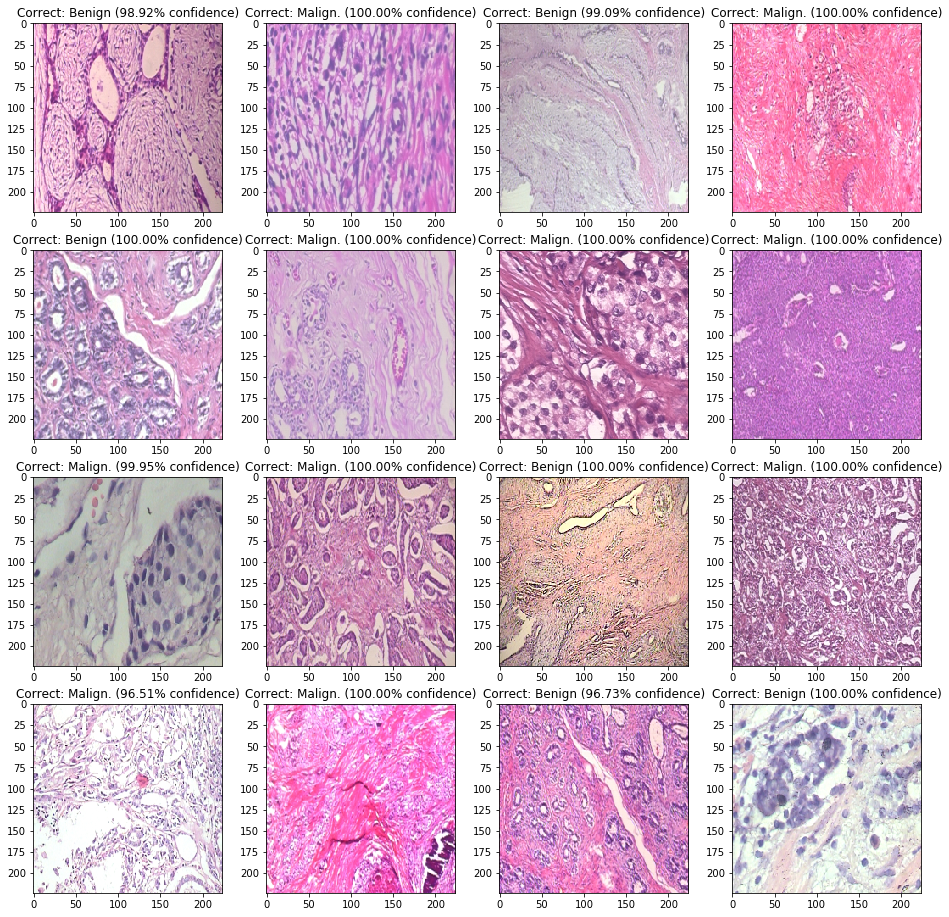

In [42]:
predictions = model.predict_classes(images_test)
print('F1 Score: %f\nRandom samples and predictions:\n' % f1_score(labels_test, predictions))

samples = 16

#random index in the test set
index = random.randint(0, len(labels_test) - samples)
#make predictions for all samples starting at that index
predictions = model.predict(images_test[index:index + samples])

fig=plt.figure(figsize=(16, 16))

for i in range(0, samples):
    ax = fig.add_subplot(samples // 4, 4, i + 1)
    title = ''
    
    confidence = predictions[i][0]
    
    if round(confidence) == labels_test[i + index]:
        title += 'Correct: '
    else:
        title += 'INCORRECT: '
    
    if labels_test[i + index] == 0:
        title += 'Benign (%.2f%% confidence)' % ((1 - confidence) * 100)
    else:
        title += 'Malign. (%.2f%% confidence)' % (confidence * 100)
    
    ax.title.set_text(title)
    plt.imshow(images_test[i + index], interpolation='nearest')
    
plt.show()